# Exercise 5 Problem 1

#### In this problem I visualize the absolute amount of seniors living in Vantaa per population grid

In [1]:
import geopandas as gpd
from pyproj import CRS
import requests
import geojson
import matplotlib.pyplot as plt

# Specify the url for web feature service
url = 'https://kartta.hsy.fi/geoserver/wfs'

# Specify parameters (read data in json format). 
# Available feature types in this particular data source: http://geo.stat.fi/geoserver/vaestoruutu/wfs?service=wfs&version=2.0.0&request=describeFeatureType
params = dict(service='WFS', 
              version='2.0.0', 
              request='GetFeature', 
              typeName='asuminen_ja_maankaytto:Vaestotietoruudukko_2018', 
              outputFormat='json')

# Fetch data from WFS using requests
r = requests.get(url, params=params)

# Create GeoDataFrame from geojson
pop = gpd.GeoDataFrame.from_features(geojson.loads(r.content))

<AxesSubplot:>

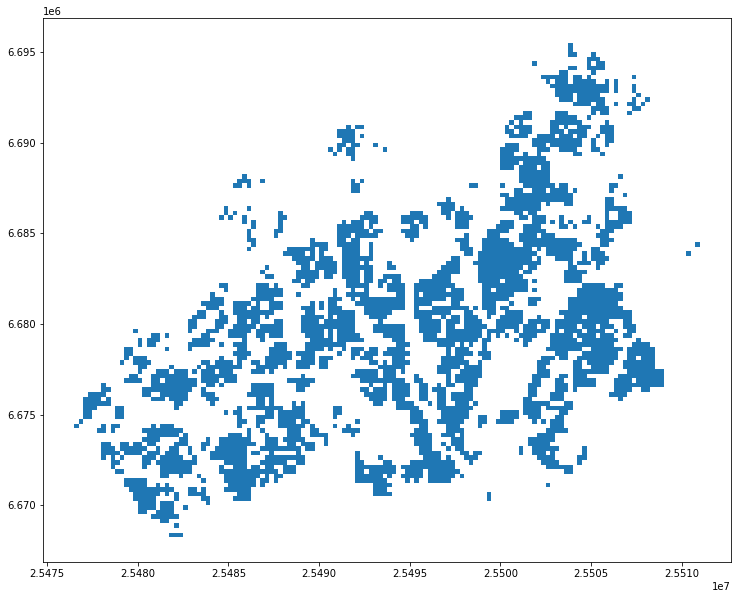

In [2]:
# PLot the population data to check that it looks correct
pop.plot(figsize=(15,10))

In [3]:
# Add column for seniors (+70 year olds)
pop["seniors"] = pop["ika70_79"] + pop["ika_yli80"]

In [4]:
# Make new dataframe with only number of seniors and geometry cells
grid = pop[["geometry", "seniors"]]

In [5]:
# Check data
grid.head()

,geometry,seniors
0,MULTIPOLYGON Z (((25476499.999 6674248.999 0.0...,10
1,MULTIPOLYGON Z (((25476749.997 6674498.998 0.0...,9
2,MULTIPOLYGON Z (((25476999.994 6675749.004 0.0...,12
3,MULTIPOLYGON Z (((25476999.994 6675499.004 0.0...,6
4,MULTIPOLYGON Z (((25476999.994 6675249.005 0.0...,5


In [6]:
# Import postal code area polygons for Uusimaa
postcode_areas_fp = "data/uusimaa_postal_code_areas.gpkg"
postal = gpd.read_file(postcode_areas_fp)

In [7]:
# Import pandas
import pandas as pd

# Import CSV-file with postal code areas per city
pks_postal = pd.read_csv("PKS_Postinumeroalueet_2019.csv", sep = ";")

# Retrieve postal codes for Vantaa
vantaa_postal = pks_postal.loc[pks_postal['Postitoimipaikka'] == "VANTAA"]

# Modify postal code data into correct format
vantaa_postal["Postinumero"] = "0" + vantaa_postal["Postinnumero"].astype(str)

<ipython-input-7-59344e31b9d6>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vantaa_postal["Postinumero"] = "0" + vantaa_postal["Postinnumero"].astype(str)


In [8]:
# Make list out of Vantaa postal codes
vantaa_postal_list = list(vantaa_postal["Postinumero"])

# Check list
vantaa_postal_list

['01200',
 '01230',
 '01260',
 '01280',
 '01300',
 '01340',
 '01350',
 '01360',
 '01370',
 '01380',
 '01390',
 '01400',
 '01420',
 '01450',
 '01480',
 '01490',
 '01510',
 '01520',
 '01530',
 '01600',
 '01610',
 '01620',
 '01630',
 '01640',
 '01650',
 '01660',
 '01670',
 '01680',
 '01690',
 '01700',
 '01710',
 '01720',
 '01730',
 '01740',
 '01750',
 '01760',
 '01770']

In [9]:
# Modify postal code dataframe to only include postal codes in Vantaa
postal = postal.loc[postal['posti_alue'].isin(vantaa_postal_list)]

In [10]:
# Add CRS to population grid
grid.crs = CRS.from_epsg(3879).to_wkt()

In [11]:
# Reproject to EPSG 3857
postal = postal.to_crs(epsg=3857)
grid = grid.to_crs(epsg=3857)

In [12]:
# Create new dataframe that includes only population grids from Vantaa
intersection = gpd.overlay(grid, postal, how='intersection')
intersection.head()

,seniors,posti_alue,he_vakiy,geometry
0,10,01630,2055.0,"POLYGON Z ((2757235.453 8458227.465 0.000, 275..."
1,7,01630,2055.0,"POLYGON Z ((2758853.428 8459240.165 0.000, 275..."
2,7,01630,2055.0,"POLYGON Z ((2759354.590 8459745.436 0.000, 275..."
3,21,01630,2055.0,"POLYGON Z ((2759356.207 8459241.803 0.000, 275..."
4,19,01630,2055.0,"POLYGON Z ((2759857.404 8459747.039 0.000, 275..."


In [13]:
# Import contextily
import contextily as ctx

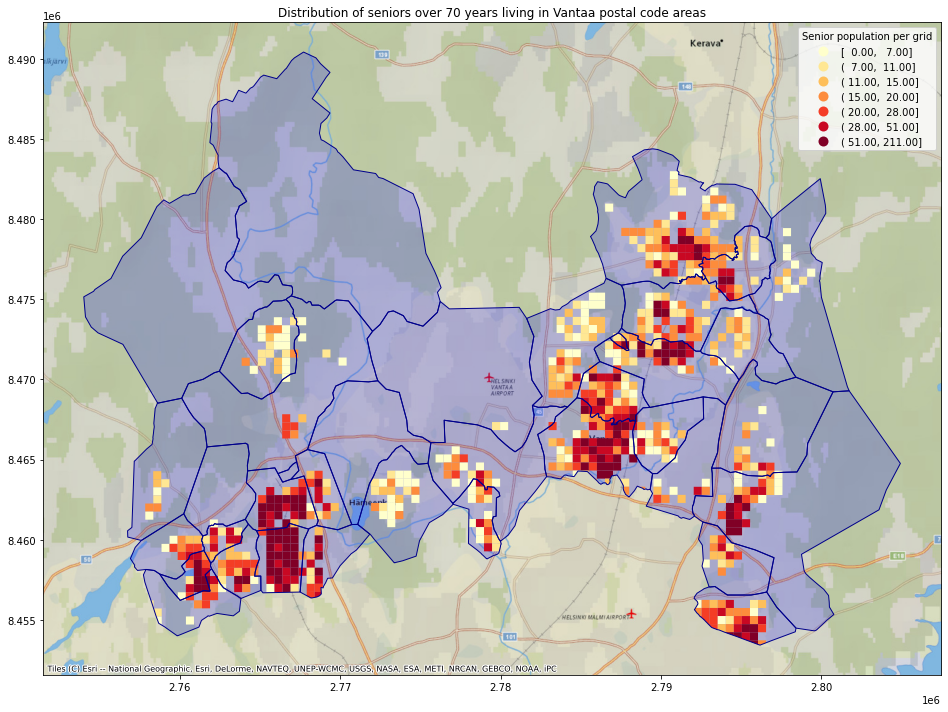

In [14]:
# Plot data
fig, ax = plt.subplots(figsize=(15,10))

# Add Vantaa postal areas to plot as transparent areas
postal.plot(ax=ax, facecolor='blue', alpha=0.2)

# Add Vantaa senior population grids to plot
intersection.plot(ax=ax,
                  column="seniors",
                  cmap='YlOrRd',
                  scheme="quantiles",
                  k=7,
                  legend=True
                 )

# Re-position the legend and set a title
#ax.get_legend().set_bbox_to_anchor((1.2,1))
ax.get_legend().set_title("Senior population per grid")

# Add Vantaa postal code edges to plot
postal.plot(ax=ax, facecolor='none', edgecolor='darkblue')

ax.title.set_text('Distribution of seniors over 70 years living in Vantaa postal code areas')

# Add basemap 
ctx.add_basemap(ax, source=ctx.providers.Esri.NatGeoWorldMap)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = r"docs/vantaa_seniors.png"
plt.savefig(outfp, dpi=300)